In [1]:
import sys
sys.path.insert(0, "/home/jogi/git/repository/meta_learner")
if "/home/jogi/.local/lib/python2.7/site-packages" in sys.path:
    sys.path.remove("/home/jogi/.local/lib/python2.7/site-packages")

import matplotlib
import matplotlib.pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
%matplotlib inline

from datetime import datetime
from pytz import timezone
import itertools
import copy

import numpy as np
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.nn import init

import numpy as np
import dill
import os
from collections import OrderedDict


from utils.experiment import Experiment
from utils.common import get_model, create_def_argparser, create_logger, softmax
from utils.common import compute_total_steps, get_evaluation_step_loss
from utils.plots import loss_plot, param_error_plot, plot_qt_probs, plot_dist_optimization_steps
from utils.plots import plot_actsb_qts, plot_image_map_data, plot_image_map_losses
from utils.plots import plot_loss_over_tsteps, plot_halting_step_stats_with_loss, plot_loss_versus_halting_step
from utils.probs import TimeStepsDist, ConditionalTimeStepDist
from utils.config import config
from val_optimizer import validate_optimizer
from utils.regression import RegressionFunction, L2LQuadratic, RegressionWithStudentT
from utils.helper import tensor_and, tensor_any
from utils.batch_handler import ACTBatchHandler
from utils.epoch import Epoch, halting_step_stats
from models.rnn_optimizer import MetaLearner, AdaptiveMetaLearnerV1, AdaptiveMetaLearnerV2
from models.sb_act_optimizer import StickBreakingACTBaseModel

from utils.regression import RegressionFunction, L2LQuadratic, neg_log_likelihood_loss, RosenBrock
from utils.regression import RegressionWithStudentT

%load_ext autoreload
%autoreload 2

In [36]:
expers_to_load = [ # BASELINE on Regression T
                  (True, "run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05"), # 25
                  (True, "run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05"), # 50 steps
                  (True, "run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05"), # 100 steps
                  # Best M-ACT on Regression T
                  (True, "run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05"),
                  # M-PACT V1 model regression T
                  (True, "run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05"),   # best
                  (False, "run_20171004_10_30_10_act_sbV3.2_45ep_nu0.7kls1.0_lr5e05"),
                  (False, "run_20171003_22_05_48_act_sbV3.2_50ep_nu0.95kls1.0_lr5e05"), 
                  ]



In [37]:
## IMPORTANT ---- NUMBER OF STEPS FOR TEST EVALUATION
MAX_EVAL_STEPS = 35

without_models = False

path_ext = None
experiments = []
models = []
new_experiments = []
explogger = None
m = 0
if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for e, exp_path in enumerate(expers_to_load):
    if exp_path[0]:
        
        if path_ext is not None:
            exp_file_path = os.path.join(path_ext, exp_path[1])
        else:
            exp_file_path = exp_path[1]
            
        exp = Experiment.load(exp_file_path, do_log=True, meta_logger=logger)
            
        if "act" in exp.args.model:
            print("{} Loading model {} (q-prob {:.2f}) / {}".format(m, exp.args.model, 
                                                                    exp.config.ptT_shape_param,
                                                                    exp.args.log_dir))
        else:
            print("{} Loading model {} / {}".format(m, exp.args.model, exp.args.log_dir))
        
        experiments.append(exp)
        m += 1
        if not without_models:
            num_inputs = 1
            if exp.args.problem == 'mlp':
                num_inputs = 3
            models.append(get_model(exp, num_inputs, retrain=True))
        new_experiments.append(Experiment(exp.args, exp.config, set_seed=True))
        new_experiments[-1].batch_handler_class = experiments[-1].batch_handler_class
        new_experiments[-1].output_dir = experiments[-1].output_dir
        new_experiments[-1].reset_val_stats()
        new_experiments[-1].meta_logger = logger
        new_experiments[-1].validation_handler_class = experiments[-1].validation_handler_class
        new_experiments[-1].training_horizon = experiments[-1].config.T
        new_experiments[-1].avg_num_opt_steps = experiments[-1].avg_num_opt_steps

INFO - created local logger for experiment with model metaV1_regression_T_25ops
INFO - INFO - loaded existing model from file logs/run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05/metaV1_regression_T_25ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_out.weight']
INFO - created local logger for experiment with model metaV1_regression_T_50ops
INFO - INFO - loaded existing model from file logs/run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05/metaV1_regression_T_50ops.pkl
INFO - Note: MetaLearner is running on GPU
INFO - ['linear1.weight', 'linear1.bias', 'lstms.0.fc_i2h.weight', 'lstms.0.fc_i2h.bias', 'lstms.0.fc_h2h.weight', 'lstms.0.fc_h2h.bias', 'lstms.1.fc_i2h.weight', 'lstms.1.fc_i2h.bias', 'lstms.1.fc_h2h.weight', 'lstms.1.fc_h2h.bias', 'linear_o

0 Loading model metaV1_regression_T_25ops / run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05
1 Loading model metaV1_regression_T_50ops / run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05
2 Loading model metaV1_regression_T_100ops / run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05
3 Loading model meta_actV1_regression_T_tau0.0018 (q-prob 0.90) / run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05
4 Loading model act_sbV3.2_regression_T_nu0.5 (q-prob 0.50) / run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05


In [38]:
# del new_experiments
new_experiments = []
unrolled_steps=200
num_of_funcs = 10000

if 'logger' in vars() or 'logger' in globals():
    pass
else:
    logger = create_logger(exper=None, file_handler=True, output_dir="/home/jogi/git/repository/meta_learner/logs")

for exper in expers_to_load:
    if exper[0]:
        
        path_to_exp = exper[1] + "/" + "exp_eval_stats_" + str(num_of_funcs) + "_" + str(unrolled_steps) +"steps.dll"
        print("Loading experiment {} / path {}".format(exper[1], path_to_exp))
        new_experiments.append(Experiment.load(path_to_exp=path_to_exp,
                                               full_path=True))
        if new_experiments[-1].meta_logger is None:
            new_experiments[-1].meta_logger = logger
print("Ready")

Loading experiment run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05 / path run_20170930_15_17_50_metaV1_45ep_25ops_lr4e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05 / path run_20170930_12_21_10_metaV1_50ep_50ops_lr4e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05 / path run_20171001_12_01_01_metaV1_30ep_100ops_lr4e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05 / path run_20171002_23_12_29_meta_actV1_45ep_tau0.0018_lr5e05/exp_eval_stats_10000_200steps.dll
Loading experiment run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05 / path run_20171003_21_29_12_act_sbV3.2_50ep_nu0.5kls1.0_lr5e05/exp_eval_stats_10000_200steps.dll
Ready


In [9]:
with open("data/test_regression_T_10000_10_1.0_10.dll", 'rb') as f:
     test_funcs = dill.load(f)
print("Ready")

Ready


INFO - Successfully saved fig figures/10regT_ALL_100_200.png


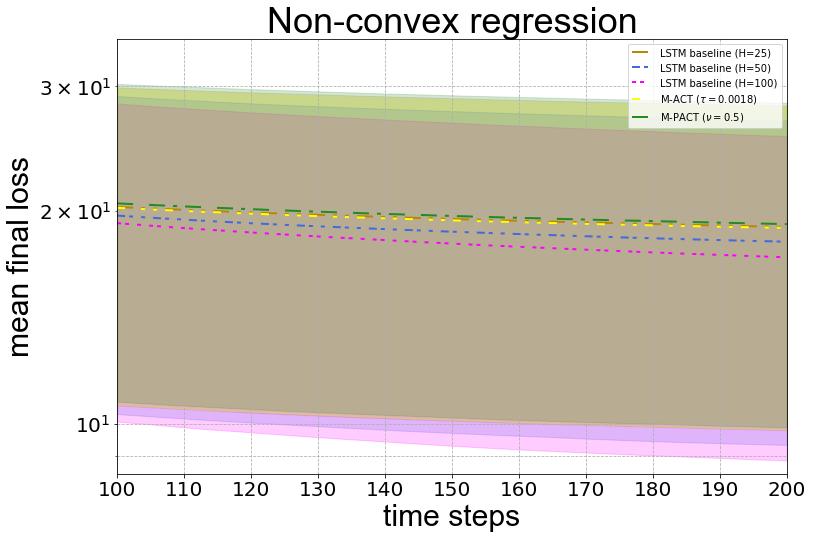

In [41]:
#new_exp_select = [new_experiments[0], new_experiments[1], new_experiments[2], new_experiments[4],
#                 new_experiments[6]] 
#, new_experiments[4]] 

part = 2
if part == 1:
    min_step = 0
    max_step = 100
    y_lim = [10,60 ]
    log_scale  = False
elif part == 2:
    min_step = 100
    max_step = 200
    log_scale = True
    y_lim=[8.5, 35]
else:
    log_scale = True
    min_step = 0
    max_step = 100
    y_lim=[8.5, 56]

best_val_runs, lowest_value = plot_loss_over_tsteps(new_experiments, do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              fig_name="10regT_ALL_"
                                              loss_type="loss",
                                              min_step=min_step,
                                              max_step=max_step,
                                              sort_exper="Non-convex regression",
                                              log_scale=log_scale,
                                              y_lim=y_lim,
                                              with_stddev=True,
                                              runID=None)

In [ ]:
# eval_new_val_expers = [new_experiments[0], new_experiments[3]] #, new_experiments[5]]

best_val_runs, lowest_value = plot_val_result(new_experiments, 
                                              do_show=True, 
                                              do_save=True, 
                                              plot_best=False,
                                              loss_type="loss",
                                              fig_name="expv5_val_results_1000_loss_10ops")

In [ ]:
# eval_expers = new_exp_only = [experiments[0], experiments[1], experiments[2]]
plot_parm_loss_steps(experiments, num_of_plots=4, do_show=True, 
                     do_save=False, loss_type="loss", log_scale=False, max_step=20,
                    fig_name="metaV2_val_loss_during_training")

In [10]:
exp_idx = 1
model = models[exp_idx]

max_steps = 200
# new_experiments[exp_idx].model_path

new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].type_prior = "geometric"


epoch_obj = Epoch()
epoch_obj.start(new_experiments[exp_idx])
print("Validating model {} ".format(model.name))
new_experiments[exp_idx].eval(epoch_obj, model, functions=test_funcs, save_run=None, save_model=False)
print("End....")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

INFO - Epoch: 400 - Evaluating 10000 test functions


Validating model act_sbV3.2_regression_T_nu0.7 


INFO - Epoch: 400 - evaluation result - time step losses
INFO - [ 56.32   42.785  37.845  35.898  34.257  32.645  31.543  30.773  30.117
  29.497  28.886  28.352  27.918  27.557  27.232  26.923  26.629  26.356
  26.111  25.888  25.679  25.482  25.297  25.123  24.96   24.804  24.655
  24.512  24.382  24.252  24.133  24.014  23.906  23.801  23.697  23.603
  23.51   23.425  23.339  23.254  23.174  23.096  23.025  22.953  22.885
  22.818  22.75   22.696  22.633  22.571  22.52   22.462  22.408  22.358
  22.303  22.261  22.209  22.157  22.112  22.074  22.032  21.984  21.948
  21.906  21.868  21.836  21.794  21.766  21.725  21.691  21.663  21.623
  21.599  21.565  21.531  21.507  21.473  21.445  21.419  21.388  21.366
  21.336  21.305  21.285  21.255  21.234  21.208  21.182  21.165  21.143
  21.112  21.093  21.07   21.051  21.034  21.008  20.99   20.968  20.948
  20.931  20.908  20.89   20.866  20.852  20.835  20.814  20.796  20.777
  20.761  20.743  20.724  20.709  20.688  20.678  20.66   20

End....


In [9]:
X = np.vstack(new_experiments[2].val_stats["halt_step_funcs"].values())

In [ ]:

exp_idx = 3
max_steps = 200
new_experiments[exp_idx].epoch = 400
new_experiments[exp_idx].config.max_val_opt_steps = max_steps
new_experiments[exp_idx].config.T = max_steps
new_experiments[exp_idx].config.qt_threshold = 0.95
new_experiments[exp_idx].reset_val_stats()
if new_experiments[exp_idx].meta_logger is None:
    new_experiments[exp_idx].meta_logger = logger
# the same object for the validation data
model = models[exp_idx]
model.opt_step_hist_val = np.zeros(new_experiments[exp_idx].config.max_val_opt_steps)
model.qt_hist_val = OrderedDict([(i, np.zeros(i)) 
                                 for i in np.arange(1, new_experiments[exp_idx].config.max_val_opt_steps + 1)])
print("Validating model {} with q-prob {:.3f}".format(model.name, experiments[exp_idx].config.ptT_shape_param))

if "act" in model.name:
    model.init_qt_statistics(new_experiments[exp_idx].config)

validate_optimizer(model, new_experiments[exp_idx], explogger, val_set=test_funcs, 
                   max_steps=max_steps, verbose=False, plot_func=False, show_plot=False, save_plot=False,
                   num_of_plots=5, save_model=False, save_qt_prob_funcs=False, 
                   save_run="exp_eval_stats_10000_"+str(max_steps) + "steps")
new_experiments[exp_idx].save("exp_eval_stats_10000_"+str(max_steps) + "steps.dll")

In [ ]:
plot_qt_probs(new_experiments[2], data_set="val", save=True, show=True, 
              plot_prior=False, height=20, width=20, add_info=True)

In [ ]:
from utils.plots import create_exper_label
num_of_plots = 13
T0 = 23
fig = plt.figure(figsize=(8, 25))

for i in range(1, num_of_plots+1):
    T = T0+i
    index = np.arange(1, T+1).astype(int)
    qt = exper.val_stats["qt_hist"][30][T]
    ax1 = plt.subplot(num_of_plots, 1, i)
    plt.bar(index, qt, 0.3, label="q(t|{})".format(T))
    ax1.legend(loc="best")
    
fig_name = "_" + "val" + "_" + create_exper_label(exper)
fig_name = os.path.join(exper.output_dir, config.qt_dist_prefix + fig_name + ".png")
plt.savefig(fig_name, bbox_inches='tight')
plt.close()

INFO - Successfully saved fig logs/run_20170814_17_04_25_metaV1_50ep_100ops_lr3e05/loss_metaV1_50ep_100ops_21:43:29.png


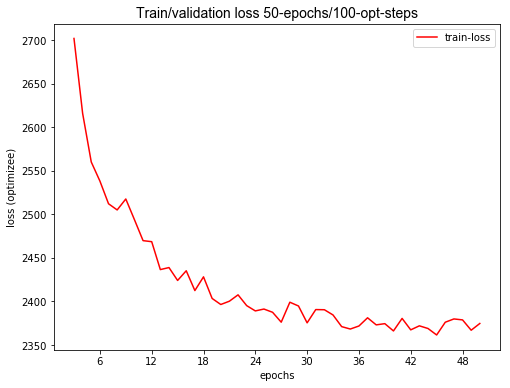

In [41]:
loss_plot(experiments[0], show=True, save=True, validation=False, only_val=False)

In [37]:
new_experiments[3].val_stats["qt_hist"][400][0:50]

array([  3.95645641e-02,   5.02193209e-03,   2.09375088e-03,
         1.68014538e-03,   1.58617760e-03,   1.63763432e-03,
         1.82115584e-03,   2.14929360e-03,   2.78002664e-03,
         4.15964677e-03,   7.62138190e-03,   1.60636712e-02,
         3.41231284e-02,   6.46539945e-02,   1.05944020e-01,
         1.45208483e-01,   1.67151677e-01,   1.53248139e-01,
         1.07916092e-01,   6.82909041e-02,   3.83919725e-02,
         1.49706040e-02,   7.08351514e-03,   3.93550375e-03,
         1.67828557e-03,   8.12438458e-04,   3.53127076e-04,
         3.28497777e-05,   1.44198164e-05,   1.14657436e-05,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
         0.00000000e+00,

INFO - Successfully saved fig logs/run_20171004_10_30_10_act_sbV3.2_45ep_nu0.7kls1.0_lr5e05/trajectory_weights_test_t0_7.png


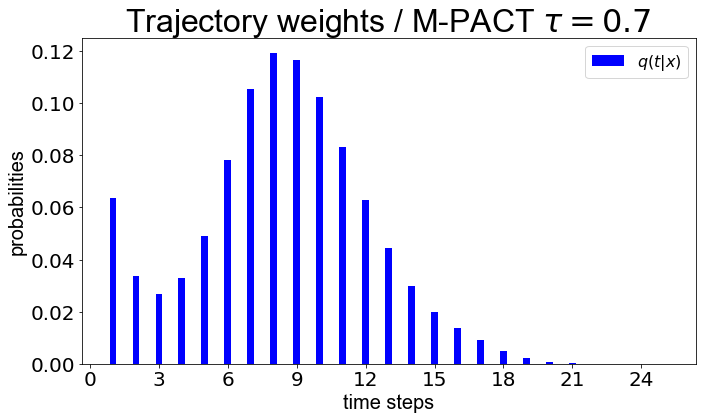

In [11]:
exper = new_experiments[1]
x_max = None
hyper_param = str.replace(str(exper.config.ptT_shape_param), '.', '_')
plot_actsb_qts(exper, data_set="eval", save=True, show=True, add_info=False, epoch=400, 
              fig_name="trajectory_weights_test" + "_t{}".format(hyper_param), 
              huge=True,
              p_title=r"Trajectory weights / M-PACT $\tau={}$".format(exper.config.ptT_shape_param),
              height=6, width=11, x_max=x_max)

INFO - Successfully saved fig logs/run_20171003_09_26_07_meta_actV1_45ep_tau0.009_lr5e05/test10000_halt_histogram.png


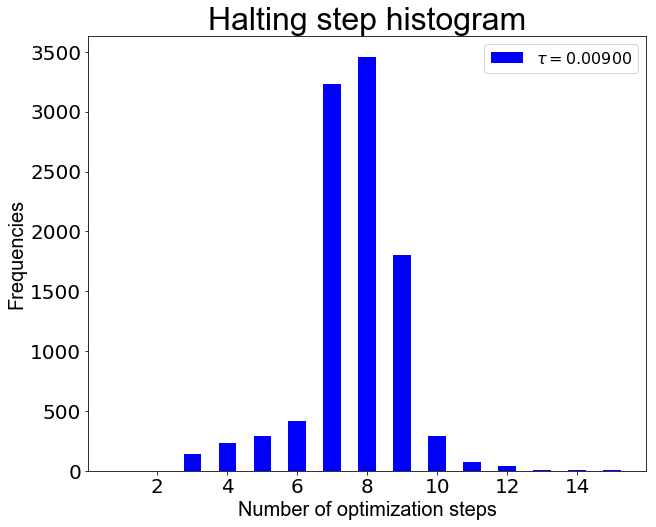

In [10]:
plot_dist_optimization_steps(new_experiments[2], data_set="eval", save=True, show=True, epoch=400, 
                            huge=True, xlimits=None, plot_title="Halting step histogram",
                            fig_name="test10000_halt_histogram")

INFO - Successfully saved fig logs/run_20171004_10_30_10_act_sbV3.2_45ep_nu0.7kls1.0_lr5e05/input_dependency_t0_7.png


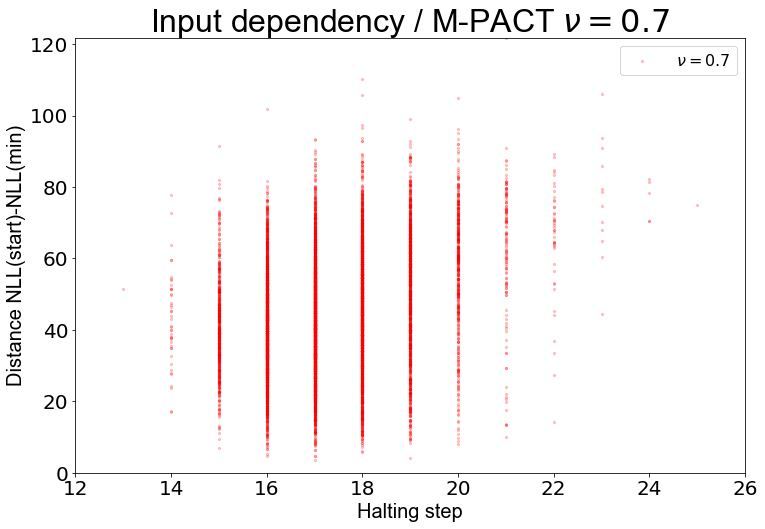

Mean 17.3652, Std 1.36184762731, Median 17, Total steps 173652


In [12]:
exper = new_experiments[1]
x_max = None
hyper_param = str.replace(str(exper.config.ptT_shape_param), '.', '_')
plot_loss_versus_halting_step(exper, epoch=400, do_show=True, do_save=True, x_max=x_max,
                              p_title="Input dependency / M-PACT" + r" $\nu={}$".format(exper.config.ptT_shape_param), 
                              huge=True, log_scale=False,
                              fig_name="input_dependency" + "_t{}".format(hyper_param))

(101, 10)
INFO - Successfully saved fig logs/run_20171004_10_30_10_act_sbV3.2_45ep_nu0.7kls1.0_lr5e05/10dregT_mpact_st_losses_t0_7.png


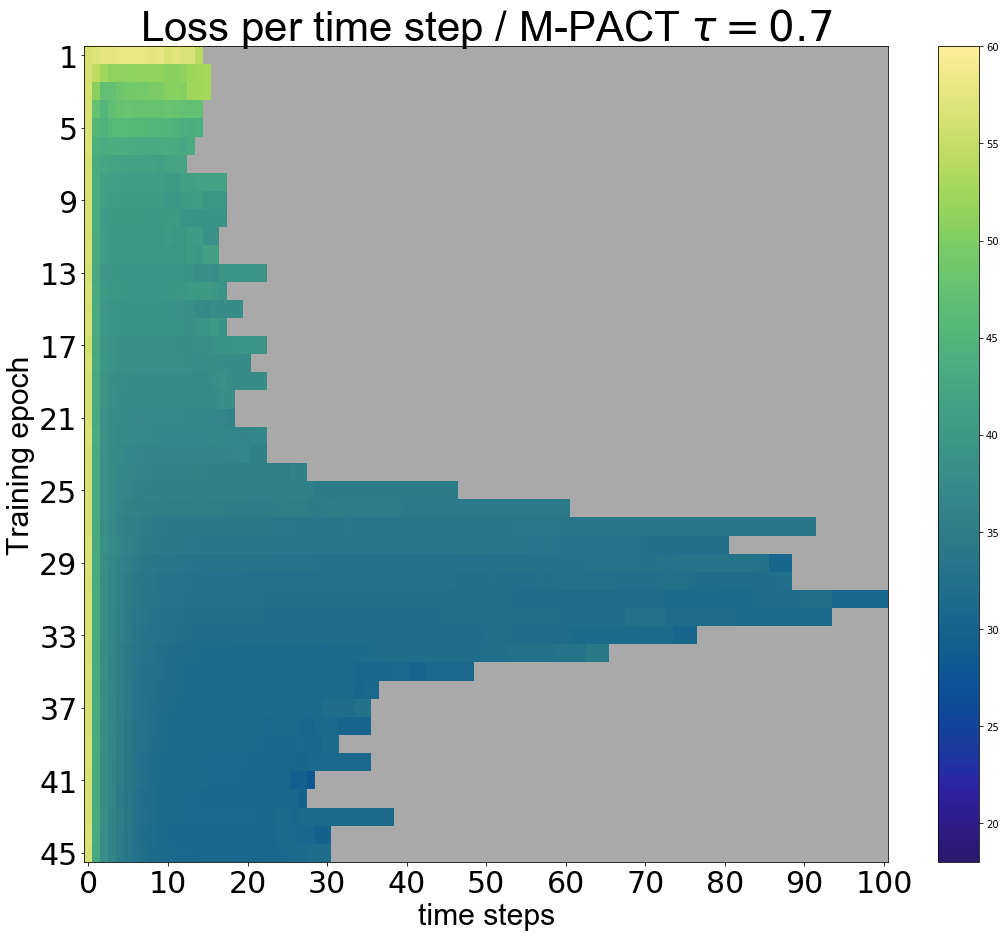

In [13]:
exper = experiments[1]
max_epoch = None
hyper_param = str.replace(str(exper.config.ptT_shape_param), '.', '_')
plot_image_map_losses(exper, fig_name="10dregT_mpact_st_losses" + "_t{}".format(hyper_param),
                      do_save=True, do_show=True, 
                      max_epoch=max_epoch, max_time_step=None, 
                      fig_title="Loss per time step / M-PACT" + r" $\tau={}$".format(exper.config.ptT_shape_param), 
                      scale= [18,60], huge=True)

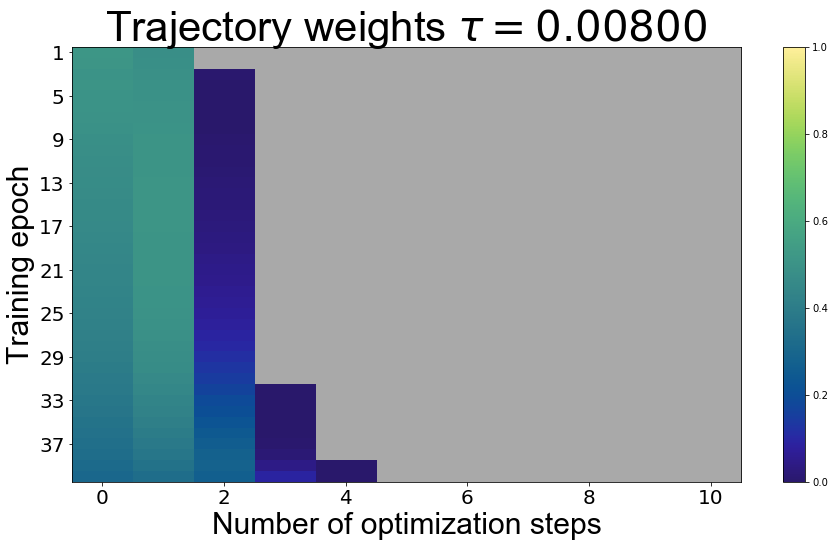

In [41]:
exper = experiments[0]
plot_image_map_data(exper, data_set="train",  width=15, height=8, do_save=False, do_show=True,
                        data="qt_value",  
                        max_epoch=None, max_time_step=11,
                        huge=True, 
                        plot_title="Trajectory weights" + r" $\tau={:.5f}$".format(exper.config.tau),
                        fig_name="trajectory_weights" + "_t{}".format(exper.config.tau))

In [32]:
expers_to_load = [# M-ACT V1 model regression
                  (True, "run_20170925_11_55_49_metaV1_65ep_50ops_lr4e05"),
                  (True, "run_20170929_11_08_20_metaV1_40ep_100ops_lr4e05"),
                  (True, "run_20171001_19_08_49_meta_actV1_40ep_tau0.004_lr4e05"),
                  (False, "run_20171001_18_06_58_meta_actV1_40ep_tau0.005_lr4e05"),
                  ]

In [3]:
test_funcs = RegressionFunction(n_funcs=10000, n_samples=10, stddev=1., x_dim=10, use_cuda=True, 
                                calc_true_params=False)
with open("data/test_regression_10000_10_1.0_10.dll", 'wb') as f:
     dill.dump(test_funcs, f)
print("Ready")

Ready


In [28]:

total_ops = 0
idx = 1
exper = experiments[idx]
new_exper = new_experiments[idx]
print(exper.args.model)
if "act_sbV3.2" in exper.args.model:
    total_ops = compute_total_steps(exper, epoch_range=None)
step_losses = get_evaluation_step_loss(new_exper, steps=[1, 10, 50, 100])
print("Total steps {}".format(total_ops))
print("Step losses")
print(np.array_str(step_losses))

act_sbV3.2_regression_T_nu0.95
Total steps 6551922
Step losses
[ 42.94036865  29.23235321  22.26463509  20.44413567  19.11506462]


In [23]:

idx = 2
new_exper = new_experiments[idx]
print(new_exper.args.model)
mean, std, median, _ , a_range = new_exper.get_step_dist_statistics(with_range=True)
print("[{}, {}] & {:.2f} & {:.2f} & {} ".format(a_range[0], a_range[1], round(mean,2), round(std,2), median))

act_sbV3.2_regression_T_nu0.95
[49, 186] & 72.24 & 19.62 & 65 


In [7]:
experiments[0].generate_figures()

INFO - Successfully saved fig logs/run_20171003_18_03_27_act_sbV3.2_65ep_nu0.3kls1.0_lr5e05/loss_train_act_sbV3.2_65ep_nu0.3kls1.0.png
(100, 65)
INFO - Successfully saved fig logs/run_20171003_18_03_27_act_sbV3.2_65ep_nu0.3kls1.0_lr5e05/loss_optimizer_train_act_sbV3.2_65ep_nu0.3kls1.0.png
INFO - Successfully saved fig logs/run_20171003_18_03_27_act_sbV3.2_65ep_nu0.3kls1.0_lr5e05/loss_eval_act_sbV3.2_65ep_nu0.3kls1.0.png
(100, 65)
INFO - Successfully saved fig logs/run_20171003_18_03_27_act_sbV3.2_65ep_nu0.3kls1.0_lr5e05/loss_optimizer_eval_act_sbV3.2_65ep_nu0.3kls1.0.png
(101, 10)
INFO - Successfully saved fig logs/run_20171003_18_03_27_act_sbV3.2_65ep_nu0.3kls1.0_lr5e05/train_step_loss_map_act_sbV3.2_65ep_nu0.3kls1.0.png
INFO - Successfully saved fig logs/run_20171003_18_03_27_act_sbV3.2_65ep_nu0.3kls1.0_lr5e05/T_dist_train.png
INFO - Successfully saved fig logs/run_20171003_18_03_27_act_sbV3.2_65ep_nu0.3kls1.0_lr5e05/gradient_statistics.png
(101, 10)
INFO - Successfully saved fig log